# Ksigma CTRV without control-input u

Hier haben wir einen erweiterten Kalman-Filter (EKF) basierend auf dem CTRV-Modell [1] entwickelt und ihn in der Ksigma-Algorithmus zur Berechnung des PL (Protection Level) angewendet.

## Datenvorverarbeitung

In [1]:
%matplotlib widget
import numpy as np
from sympy import symbols, Matrix, sin, cos, init_printing
import sympy as sp
import ast
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from bagpy import bagreader
from numpy import array

In [2]:
# import data from recording at Klitten FVZ
results_file = "./Klitten/loc_results_2023-11-01-12-53-52_0.bag"
sensor_file = "./Klitten/recordedData_sensors_locpc_2023-11-01-12-53-52_0.bag"

result_reader = bagreader(results_file)
sensor_reader = bagreader(sensor_file)


# Thius function extracts the sensordata into CSV-files
map_path = result_reader.message_by_topic(topic="/odometry/filtered/map")
# odom_path = result_reader.message_by_topic(topic="/odometry/filtered/odom")
# gps_odometry_path  = result_reader.message_by_topic(topic="/odometry/gps")
imu_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/imu")
# speed_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/speed")
# steeringAngle_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/steeringAngle")
# gnss_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/gnss")
# imu_anavs = sensor_reader.message_by_topic(topic="/localization_pc/sensor/anavs/imu")
# navsat_anavs = sensor_reader.message_by_topic(topic="/localization_pc/sensor/anavs/navsat")


# You can then use Pandas to read the files.
df_map_path = pd.read_csv(map_path)  
# df_odom_path = pd.read_csv(odom_path)  
# df_gps_path = pd.read_csv(gps_odometry_path)
# df_speed = pd.read_csv(speed_oem)
df_imu = pd.read_csv(imu_oem)

# 我写的
# df_imu_anavs = pd.read_csv(imu_anavs)
# df_navsat_anvas = pd.read_csv(navsat_anavs)

[INFO]  Data folder ./Klitten/loc_results_2023-11-01-12-53-52_0 already exists. Not creating.
[INFO]  Data folder ./Klitten/recordedData_sensors_locpc_2023-11-01-12-53-52_0 already exists. Not creating.


Die Zeitdaten von `header.stamp.secs` sollen verschoben werden, sodass sie ab 0 Sekunden beginnen.

In [3]:
df_map_path['header.stamp.secs'] = df_map_path['header.stamp.secs'] - df_map_path['header.stamp.secs'].iloc[0]
df_imu['header.stamp.secs'] = df_imu['header.stamp.secs'] - df_imu['header.stamp.secs'].iloc[0]

Die Anzeigeformatierung für DataFrame einstellen

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 20)

Eine neue Spalte `secs.nsecs` zwischen `header.stamp.secs` und `header.stamp.nsecs` einfügen, sodass der Zeitstempel in Sekunden mit Dezimalstellen dargestellt wird.

In [5]:
# 计算新列
df_imu['secs.nsecs'] = df_imu['header.stamp.secs'] + df_imu['header.stamp.nsecs'] * 1e-9
df_imu['secs.nsecs'] = df_imu['secs.nsecs'].round(9)
# 调整列的位置，将 'secs.nsecs' 放到 'header.stamp.nsecs' 后面
columns = df_imu.columns.tolist()
index = columns.index('header.stamp.nsecs') + 1  # 获取目标列的索引并加1
columns.insert(index, columns.pop(columns.index('secs.nsecs')))  # 移动 secs.nsecs 列

# 重新排列列顺序
df_imu = df_imu[columns]

In [6]:
# 计算新列
df_map_path['secs.nsecs'] = df_map_path['header.stamp.secs'] + df_map_path['header.stamp.nsecs'] * 1e-9
df_map_path['secs.nsecs'] = df_map_path['secs.nsecs'].round(9)
# 调整列的位置，将 'secs.nsecs' 放到 'header.stamp.nsecs' 后面
columns = df_map_path.columns.tolist()
index = columns.index('header.stamp.nsecs') + 1  # 获取目标列的索引并加1
columns.insert(index, columns.pop(columns.index('secs.nsecs')))  # 移动 secs.nsecs 列

# 重新排列列顺序
df_map_path = df_map_path[columns]

## System Design

### Zustand des Modells
Das CTRV-Modell (*Constant Turn Rate and Velocity*) ist ein gängiges Fahrzeugbewegungsmodell, das verwendet wird, um die Bewegung eines Fahrzeugs in Szenarien mit gleichmäßiger Kurvenfahrt zu beschreiben. Es wird angenommen, dass die Kurvendrehgeschwindigkeit (Winkelgeschwindigkeit \( \omega \)) konstant bleibt und die Beschleunigung vernachlässigt wird.
Der Zustandsvektor wird normalerweise definiert als:

$$
\mathbf{x} =
\begin{bmatrix}
x & y & \theta & v & \omega
\end{bmatrix}^\mathsf{T}
$$

- $x, y$: Position des Fahrzeugs im globalen Koordinatensystem
- $\theta$: Orientierung (Fahrtrichtung)
- $v$: Geschwindigkeit
- $\omega$: Winkelgeschwindigkeit/yaw rate

## Zustandsübergangsgleichung

Unter der Annahme eines diskreten Zeitintervalls (\(\Delta t\)) kann der Zustandsübergang wie folgt beschrieben werden:

$$
\mathbf{x}_{k+1} = 
\begin{bmatrix}
x_k + \frac{v_k}{\omega_k} [\sin(\theta_k + \omega_k \Delta t) - \sin(\theta_k)] \\
y_k + \frac{v_k}{\omega_k} [\cos(\theta_k) - \cos(\theta_k + \omega_k \Delta t)] \\
\theta_k + \omega_k \Delta t \\
v_k \\
\omega_k
\end{bmatrix}
$$

Falls $\omega$ = 0, wird die Gleichung für eine gerade Bewegung vereinfacht:

$$
\mathbf{x}_{k+1} = 
\begin{bmatrix}
x_k + v_k \cos(\theta_k) \Delta t \\
y_k + v_k \sin(\theta_k) \Delta t \\
\theta_k \\
v_k \\
\omega_k
\end{bmatrix}
$$


#### Die für die Zustansmatrix (X) erforderlichen Daten aus den Sensordaten extrahieren.

In [7]:
# z, cov_z = func_z(k, dt_step)   

def func_z(k, dt_step):
    t = k * dt_step

    # 从 df_map_path['secs.nsecs'] 中找到与 t 值最接近的值的 index
    idx1                   = (df_map_path['secs.nsecs'] - t).abs().idxmin()
    
    # 获取该 index 对应的测量值
    x                      = df_map_path.loc[idx1, 'pose.pose.position.x']
    y                      = df_map_path.loc[idx1, 'pose.pose.position.y']
    theta                  = df_map_path.loc[idx1, 'pose.pose.orientation.z']
    v                      = df_map_path.loc[idx1, 'twist.twist.linear.x']

    # 获取该 index 对应的测量值的协方差
    cov_pose_str           = df_map_path.loc[idx1, 'pose.covariance']
    cov_pose_parsed_matrix = ast.literal_eval(cov_pose_str)
    cov_pose_matrix        = np.array(cov_pose_parsed_matrix).reshape(6, 6)
    cov_pose               = cov_pose_matrix[0:3, 0:3]  # cov_x, cov_y, cov_xy und cov_theta sind drinnen 

    cov_v_str              = df_map_path.loc[idx1, 'twist.covariance']
    cov_v_parsed_matrix    = ast.literal_eval(cov_v_str)
    cov_v                  = cov_v_parsed_matrix[0]

    # 从 df_imu['secs.nsecs'] 中找到与 t 值最接近的 index
    idx2                   = (df_imu['secs.nsecs'] - t).abs().idxmin()

    # 获取该 index 对应的测量值及其协方差
    omega                  = df_imu.loc[idx2, 'angular_velocity.z']
    cov_omega              = df_imu.loc[idx2, 'angular_velocity_covariance_8']

    # 构建测量矩阵 z 及其方差矩阵 cov_z
    z                      = Matrix([x, y, theta, v, omega])
    cov_z                  = np.zeros((5, 5))  # 创建5x5的零矩阵
    cov_z[:3, :3]          = cov_pose
    cov_z[3, 3]            = cov_v
    cov_z[4, 4]            = cov_omega

    return z, cov_z
    
# k = 10000
# dt_step = 0.1
# z, cov_z = func_z(k, dt_step)   

In [8]:
# Test
# k = 10000
# dt_step = 0.1
# z, cov_z = func_z(k, dt_step)  
# df_map_path.iloc[idx1]

### Prädiktion

In [9]:
df_map_path.head()

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,secs.nsecs,header.frame_id,child_frame_id,pose.pose.position.x,pose.pose.position.y,pose.pose.position.z,pose.pose.orientation.x,pose.pose.orientation.y,pose.pose.orientation.z,pose.pose.orientation.w,pose.covariance,twist.twist.linear.x,twist.twist.linear.y,twist.twist.linear.z,twist.twist.angular.x,twist.twist.angular.y,twist.twist.angular.z,twist.covariance
0,1.698840e+09,0,0,546918154,0.546918,map,base_link,0.00000,0.000000,0.0,0.0,0.0,0.000000,1.0,"(100.0, 0.0, 0.0...",0.00000,0.000000,0.0,0.0,0.0,0.000000,"(1.0, 0.0, 0.0, ..."
1,1.698840e+09,1,0,546918154,0.546918,map,base_link,0.00000,0.000000,0.0,0.0,0.0,0.000000,1.0,"(100.0, 0.0, 0.0...",0.00000,0.000000,0.0,0.0,0.0,0.000000,"(1.0, 0.0, 0.0, ..."
2,1.698840e+09,2,0,546918154,0.546918,map,base_link,0.00000,0.000000,0.0,0.0,0.0,0.000000,1.0,"(100.0, 0.0, 0.0...",0.00000,0.000000,0.0,0.0,0.0,0.000000,"(1.0, 0.0, 0.0, ..."
3,1.698840e+09,3,0,546918154,0.546918,map,base_link,0.00000,0.000000,0.0,0.0,0.0,0.000000,1.0,"(100.0, 0.0, 0.0...",0.00000,0.000000,0.0,0.0,0.0,0.000000,"(1.0, 0.0, 0.0, ..."
4,1.698840e+09,4,0,587237358,0.587237,map,base_link,-0.00018,-0.000176,0.0,0.0,0.0,-0.000001,1.0,(100.03322610457...,-0.00894,-0.008754,0.0,0.0,0.0,-0.000548,(1.0020168124154...


### Definition von Φₛ

Φₛ ist die Intensität des Sensorsrauschens pro Zeiteinheit, also die Leistungsdichtespektrum. Es spiegelt die statistischen Eigenschaften des Rauschens wider und hängt mit dem Abtastprozess des Sensors zusammen, nicht jedoch mit der Aktualisierungsrate des Filters.

Formel:
$$
\Phi_s = \frac{\sigma^2}{\Delta t_s}
$$

Wobei:
- **σ²**: Die Varianz der gemessenen Sensordaten.
- **Δtₛ**: Der Abtastintervall des Sensors.

Daher ist es bei der Berechnung von **Φₛ** notwendig, das Abtastintervall des Sensors **Δtₛ** zu verwenden.


In [10]:
# PSD = power spectral density
def PSD_v():
    Varianz_v = np.var(df_map_path["twist.twist.linear.x"]*3.6)
    f_v = 100  # Hz
    Phi_v =  Varianz_v / (1 / f_v)
    print("Varianz_v:", Varianz_v)
    print("Phi_v:",Phi_v)    
    return Phi_v

# Der mit dieser Methode berechnete Phi_v ist zu groß.
# PSD_v() 

In [11]:
# PSD = power spectral density
def PSD_omega():
    Varianz_omega = np.var(df_imu["angular_velocity.z"])
    f_omega = 50  # Hz
    Phi_omega =  Varianz_omega / (1 / f_omega)
    print("Varianz_omega:", Varianz_omega)
    print("Phi_omega:",Phi_omega)    
    return Phi_omega

# Der mit dieser Methode berechnete Phi_omega ist zu groß.
# PSD_omega() 

In [12]:
# v = df_map_path["twist.twist.linear.x"] * 3.6
# v_max = v.abs().max()
# v_max

Prozessgeräusch Q

In [13]:
def Q_evaluated(X, dt, Phi): 
    x, y, theta, v, omega, time = symbols('x y theta v omega T')
    Phi_v, Phi_omega            = symbols('Phi_v Phi_omega')
    t                           = symbols('t')
    Zustandsmatrix              = Matrix([x, y, theta, v, omega])  # Zustandsmatrix
    
    subs_Q = {x:         float(X[0, 0]), 
              y:         float(X[1, 0]), 
              theta:     float(X[2, 0]), 
              v:         float(X[3, 0]), 
              omega:     float(X[4, 0]), 
              time:      float(dt),
              Phi_v:     float(Phi[0]),
              Phi_omega: float(Phi[1])}
    
    if subs_Q[omega] != 0:
        f_xu = Matrix(
            [x + v/omega * (sin(theta + omega*time) - sin(theta)), 
             y + v/omega * (cos(theta) - cos(theta + omega*time)),  
             theta + omega*time,
             v,
             omega])
    else:
        f_xu = Matrix(
            [x + v * time * cos(theta),
             y + v * time * sin(theta),
             theta,
             v,
             omega])
        
    F = f_xu.jacobian(Zustandsmatrix) 
    Qc  = Matrix([[0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, Phi_v, 0],
                  [0, 0, 0, 0, Phi_omega]])
    Q   = sp.integrate(F * Qc * F.T, (t, 0, time))
    
    Q_evaluated = np.array(Q.subs(subs_Q)).astype(float)
    return Q_evaluated

In [14]:
# Test für Q_evaluated
# k = 1200
# dt_step = 0.1
# z, cov_z = func_z(k, dt_step)
# Phi_v = PSD_v()
# Phi_omega = PSD_omega()
# Phi = np.array([Phi_v, Phi_omega])  # Phi_v, Phi_omega
# Q_evaluated(X=z, dt=dt_step, Phi=Phi)

In [15]:
from filterpy.common import Q_discrete_white_noise
def Q_dwn_CTRV(dt):
    Q = np.ones((5, 5)) * 0.1
    Q[0:4, 0:4] = Q_discrete_white_noise(4, dt=1, var=1)
    return Q
Q = Q_dwn_CTRV(dt=1)
Q

array([[0.02777778, 0.08333333, 0.16666667, 0.16666667, 0.1       ],
       [0.08333333, 0.25      , 0.5       , 0.5       , 0.1       ],
       [0.16666667, 0.5       , 1.        , 1.        , 0.1       ],
       [0.16666667, 0.5       , 1.        , 1.        , 0.1       ],
       [0.1       , 0.1       , 0.1       , 0.1       , 0.1       ]])

In [16]:
from sympy import symbols, Matrix, sin, cos, init_printing
from numpy import array
# x, y, theta, v, omega, time = symbols('x y theta v omega t')

# Jacobian Matrix berechnen
def F_J_evaluated(X, dt): 
    x, y, theta, v, omega, time = symbols('x y theta v omega t')
    subs_FJ = {x:     float(X[0, 0]), 
               y:     float(X[1, 0]), 
               theta: float(X[2, 0]), 
               v:     float(X[3, 0]), 
               omega: float(X[4, 0]), 
               time:  float(dt)}
    if subs_FJ[omega] != 0:
        f_xu = Matrix(
            [x + v/omega * (sin(theta + omega*time) - sin(theta)), 
             y + v/omega * (cos(theta) - cos(theta + omega*time)),  
             theta + omega*time,
             v,
             omega])
    else:
        f_xu = Matrix(
            [x + v * time * cos(theta),
             y + v * time * sin(theta),
             theta,
             v,
             omega])
    F_J = f_xu.jacobian(Matrix([x, y, theta, v, omega])) 
    F_J_evaluated = array(F_J.subs(subs_FJ)).astype(float)
    return F_J_evaluated

def driving(X, dt):
    heading_angle = X[2, 0]
    velocity      = X[3, 0]
    yaw_rate      = X[4, 0]
    
    if yaw_rate != 0:
        radius        = velocity/yaw_rate  # R = v / ω
        beta          = yaw_rate * dt
        dX = np.array([
            [radius * (sin(heading_angle + beta) - sin(heading_angle))],
            [radius * (cos(heading_angle) - cos(heading_angle + beta))],
            [beta],
            [0],
            [0]
        ])
    else:
        dX = np.array([
            [velocity * dt * cos(heading_angle)],
            [velocity * dt * sin(heading_angle)],
            [0],
            [0],
            [0]
        ])

    return X + dX

def predict(X, P, dt):
    predict_X = driving(X=X, dt=dt)
    F = F_J_evaluated(X, dt)
    # Q = Q_evaluated(X=X, dt=dt_step, Phi=np.array([1, 1]))
    predict_P = F @ P @ F.T  + Q# 这里还需要构建一个噪声矩阵 Q
    return predict_X, predict_P


#### Test

In [17]:
# Test
# k = 10000
# dt_step = 0.1
# z, cov_z = func_z(k, dt_step) 
# predict_X, predict_P = predict(X=z, P=cov_z, dt = dt_step)
# predict_X

### Update

1. Wenn Sensoren *v* und *ω* direkt messen können, wird empfohlen, den Messwertvektor *z* auf 
   \\([x, y, \theta, v, \omega]^T\\) zu erweitern und gleichzeitig die Beobachtungsmatrix *H* in eine 
   \\(5 \times 5\\)-Einheitsmatrix zu ändern.

2. Wenn die Sensoren *v* und *ω* nicht genau messen können oder die Messwerte stark verrauscht sind, 
   kann die ursprüngliche \\(3 \times 5\\)-Beobachtungsmatrix beibehalten werden. 
   In diesem Fall werden *v* und *ω* indirekt über die Kovarianzausbreitung aktualisiert.

In [18]:
# H = Matrix([[1, 0, 0, 0, 0], 
#             [0, 1, 0, 0, 0],
#             [0, 0, 1, 0, 0]])

H = Matrix([[1, 0, 0, 0, 0], 
            [0, 1, 0, 0, 0],
            [0, 0, 1, 0, 0], 
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]])
H

Matrix([
[1, 0, 0, 0, 0],
[0, 1, 0, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 1, 0],
[0, 0, 0, 0, 1]])

In [19]:
def h_x(X):
    """convert prediction to measurement"""
    h_x = H @ X
    return h_x
    
# Test
# k = 10000
# dt_step = 0.1
# z, cov_z = func_z(k-1, dt_step) 
# predict_X, predict_P = predict(X=z, P=cov_z, dt = dt_step)
# hx = h_x(predict_X)
# z, cov_z = func_z(k, dt_step) 
# hx

In [20]:
# Roger R Labbe Jr. Kalman_and_Bayesian_Filters_in_Python.
def residual(z, hx):
    """ compute residual (a-b) between measurements containing 
    [x, y, theta, v, omega]. theta is normalized to [-pi, pi)"""
    y = z - hx
    y[2] = y[2] % (2 * np.pi)    # force in range [0, 2*pi)
    if y[2] > np.pi:             # move to [-pi, pi)
        y[2] -= 2 * np.pi
    return y
# y = residual(z, hx)
# y

In [21]:
# 这个函数可以不要了，因为 cov_z 就是 R
# Measurement Noise Matrix
# def R_matrix(k, dt_step):
#     z, cov_z          = func_z(k, dt_step)                    # func_z用来获取测量值和每次更新阶段时刻k所需的最新状态矩阵 X 的噪声协方差
#     cov_x             = cov_z[0]
#     cov_y             = cov_z[1]
#     cov_xy            = cov_z[2]
#     cov_theta         = cov_z[3]
#     
#     # Measurement Noise Matrix，在不重新定义整个 EKF 实例 的情况下，动态更新测量噪声协方差矩阵 R。直接在循环中动态修改 ekf.R 即可，而无需重新实例化扩展卡尔曼滤波器。这种方式既高效又灵活。
#     diagonal_elements = [cov_x, cov_y, cov_theta]             # 对角元素
#     R                 = np.diag(diagonal_elements)
#     R[0, 1]           = cov_xy
#     R[1, 0]           = cov_xy
#     return R

In [22]:
def update(X, P, k, dt_step):
    X_p      = X
    P_p      = P
    
    # calculate residual y
    z, cov_z = func_z(k, dt_step)
    hx       = h_x(X_p)
    y        = residual(z, hx)

    # Kalman Gain Matrix
    R        = cov_z
    S        = H @ P_p @ H.T + R  # 残差协方差
    K        = P_p @ H.T @ S.inv()  # 卡尔曼增益矩阵

    X_update = X_p + K @ y
    I        = np.eye(5)  # 后期这个 5 可以设置为一个名为 dim 的变量，就不用单独来到这里修改了  
    P_update = (I - K @ H) @ P_p
    
    return X_update, P_update

In [23]:
"""def update(X, P, k, dt_step):
    X_p      = X
    P_p      = P
    
    # calculate residual y
    z, cov_z = func_z(k, dt_step)
    hx       = h_x(X_p)
    y        = residual(z, hx)

    # Kalman Gain Matrix
    R        = cov_z
    S        = H @ P_p @ H.T + R  # 残差协方差
    K        = P_p @ H.T @ S.inv()  # 卡尔曼增益矩阵

    X_update = X_p + K @ y
    I        = np.eye(5)  # 后期这个 5 可以设置为一个名为 dim 的变量，就不用单独来到这里修改了  
    P_update = (I - K @ H) @ P_p

    intermediate_vars = {
        "X_p": X_p,
        "P_p": P_p,
        "z": z,
        "cov_z": cov_z,
        "hx": hx,
        "y": y,
        "R": R,
        "S": S,
        "K": K,
        "X_update": X_update,
        "I": I,
        "P_update": P_update
    }
    intermediate_series = pd.Series(intermediate_vars)
    
    return X_update, P_update, intermediate_series"""

'def update(X, P, k, dt_step):\n    X_p      = X\n    P_p      = P\n    \n    # calculate residual y\n    z, cov_z = func_z(k, dt_step)\n    hx       = h_x(X_p)\n    y        = residual(z, hx)\n\n    # Kalman Gain Matrix\n    R        = cov_z\n    S        = H @ P_p @ H.T + R  # 残差协方差\n    K        = P_p @ H.T @ S.inv()  # 卡尔曼增益矩阵\n\n    X_update = X_p + K @ y\n    I        = np.eye(5)  # 后期这个 5 可以设置为一个名为 dim 的变量，就不用单独来到这里修改了  \n    P_update = (I - K @ H) @ P_p\n\n    intermediate_vars = {\n        "X_p": X_p,\n        "P_p": P_p,\n        "z": z,\n        "cov_z": cov_z,\n        "hx": hx,\n        "y": y,\n        "R": R,\n        "S": S,\n        "K": K,\n        "X_update": X_update,\n        "I": I,\n        "P_update": P_update\n    }\n    intermediate_series = pd.Series(intermediate_vars)\n    \n    return X_update, P_update, intermediate_series'

In [24]:
# Test
# k = 810
# dt_step = 0.5
# X, P = func_z(k-1, dt_step) 
# predict_X, predict_P = predict(X, P, dt=dt_step)
# X_update, P_update, intermediate_series = update(X=predict_X, P=predict_P, k=k, dt_step=dt_step)
# z, cov_z = func_z(k, dt_step)
# intermediate_series["z"]

## run_CTRV_EKF

In [25]:
def ksigma(df_EKF_update):
    # 定义计算 PL_ksigma_posH 的函数
    def calculate_PL_ksigma_posH(P):
        P = np.array(P, dtype=float)
        sigma_E = P[0, 0]
        sigma_N = P[1, 1]
        sigma_EN = P[0, 1]
        sigma_H = np.sqrt((sigma_E**2 + sigma_N**2) / 2) + np.sqrt(((sigma_E**2 + sigma_N**2) / 2)**2 + sigma_EN**2)
        K_posH = 6
        PL_ksigma_posH = K_posH * sigma_H
        return PL_ksigma_posH
    # 对 df_EKF_update['P'] 的每一行应用函数，生成新列 df_EKF_update['PL_ksigma_posH']
    df_EKF_update['PL_ksigma_posH'] = df_EKF_update['P'].apply(calculate_PL_ksigma_posH)
    return df_EKF_update

In [28]:
import os
from filterpy.stats import plot_covariance_ellipse
def run_CTRV_EKF(dt_step      = 0.5,             # secs, dt不可以直接指定固定值，而是要根据测量数据的时间戳进行决定，或者确定一个dt，截取传感器数据中与之时刻最接近的数据
                 dt_track     = 0.1,
                 sim_duration = 20):
    plt.clf()                                    # 清除上一次运行所绘图像
    z_0, cov_z0  = func_z(k=0, dt_step=dt_step)
    X            = z_0.copy()                    # X_0
    P            = cov_z0.copy()                 # P_0, 之后也可以给P_0写一个函数，这里先这么着吧
    # u, cov_u     = func_u(k=0, dt_step=dt_step)  # u_0, cov_u0
    track        = []                            # 用于记录汽车的运行轨迹
    k            = 0                             # timestep for prediction and update
    sim_X        = z_0.copy()
    step         = int(dt_step / dt_track)                            
    ellipse_step = 20 * step
    track_step   = int(sim_duration / dt_track)

    # 初始化用于存储更新数据的列表
    update_data = []

    # k_met = False                                # 第一次的Kovarianz太大，可以不画椭圆
                                                 # 但是对于不含u的CTRV而言是否需要k_met还需斟酌
    for i in range(track_step):
            
        # driving(X, u, dt)
        sim_X = driving(sim_X, dt_track)                          # simulate the driving model of the car
        track.append(sim_X)                                       # 这里并不多余，因为要绘制汽车运行的轨迹图，当 ω ≠ 0 时，两次更新点之间的轨迹并不是一条直线，所以需要适当的增加一些轨迹点使轨迹图看起来平滑

        # 判断是否需要设置 k_met 为 True
        # if not k_met and k <= 10:
        #     k_met = True
        
        if i % step == 0:
            k         = k + 1
            X, P = predict(X, P, dt=dt_step)  # predict

            if i % ellipse_step == 0:
            # if i % ellipse_step == 0 and k >= 10:
                plot_covariance_ellipse(
                    (X[0,0], X[1,0]), P[0:5, 0:5], 
                    std=1, facecolor='k', alpha=0.3)                 # 设置predict阶段的协方差椭圆的颜色为黑色，透明度为 0.3（范围是 0 到 1）

            X, P = update(X=X, P=P, k=k, dt_step=dt_step)  # update
            P = np.array(P.tolist(), dtype=float)  # from "type: <class 'sympy.matrices.dense.MutableDenseMatrix'>" to "type: <class 'numpy.ndarray'>"
            
            if i % ellipse_step == 0:
            # if i % ellipse_step == 0 and k >= 10:
                plot_covariance_ellipse(
                    (X[0,0], X[1,0]), P[0:5, 0:5], 
                     std=1, facecolor='g', alpha=0.8)

            # 将当前的时间、k值、X和P保存到 update_data 中
            update_data.append({  
                "time/s": k * dt_step,
                "time step k": k,
                "X": X.tolist(),  # 转为列表格式存储
                "P": P.tolist()   # 转为列表格式存储
            })
            
            sim_X = X
            track.append(sim_X)    
        if i == track_step - 1:  # testcode, should be deleted after testing
            print(f'Pu_{k}:{P}:')

    # 创建 DataFrame
    df_EKF_update = pd.DataFrame(update_data)
    df_ksigma = ksigma(df_EKF_update)
        
    track = np.array(track)  # 假设 track 是您的轨迹数据
    plt.plot(track[:, 0], track[:, 1], color='k', lw=2)
    plt.axis('equal')
    plt.grid(True)

    # 设置动态标题
    title_text = f"Klitten EKF\nsim_duration = {sim_duration}, dt_step = {dt_step}, dt_track = {dt_track}"
    plt.title(title_text)

    # 动态生成文件夹路径
    save_dir = "C:/Users/wq138/OneDrive - mailbox.tu-dresden.de/Diplomarbeit/sim_Ergebnisse/"
    os.makedirs(save_dir, exist_ok=True)

    # 生成基础文件名
    base_name = f"Klitten_EKF_sim_duration={sim_duration}_dt_step={dt_step}_dt_track={dt_track}"
    file_extension = ".png"

    # 初始化计数器为 1
    counter = 1
    save_path = os.path.join(save_dir, f"{base_name}({counter}){file_extension}")

    # 检查文件是否已存在，如果存在递增计数器
    while os.path.exists(save_path):
        counter += 1
        save_path = os.path.join(save_dir, f"{base_name}({counter}){file_extension}")

    # 保存图片
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Chart has been saved in: {save_path}")

    return df_ksigma
# 图像大小还需要调整，貌似每次都会被上一次的数据覆盖


Pu_2400:[[ 2.10733052e-03  7.31623384e-04 -1.04311089e-07  2.03214175e-04
  -1.97943505e-05]
 [ 7.31623384e-04  1.13924750e-03  1.31989446e-07 -2.75521571e-04
  -1.23426115e-05]
 [-1.04311092e-07  1.31989412e-07  4.76544125e-07  4.11613995e-07
   2.22037732e-09]
 [ 2.03214175e-04 -2.75521571e-04  4.11614004e-07  5.43145654e-04
  -1.24664185e-06]
 [-1.97943505e-05 -1.23426115e-05  2.22037907e-09 -1.24664185e-06
   8.93450083e-04]]:


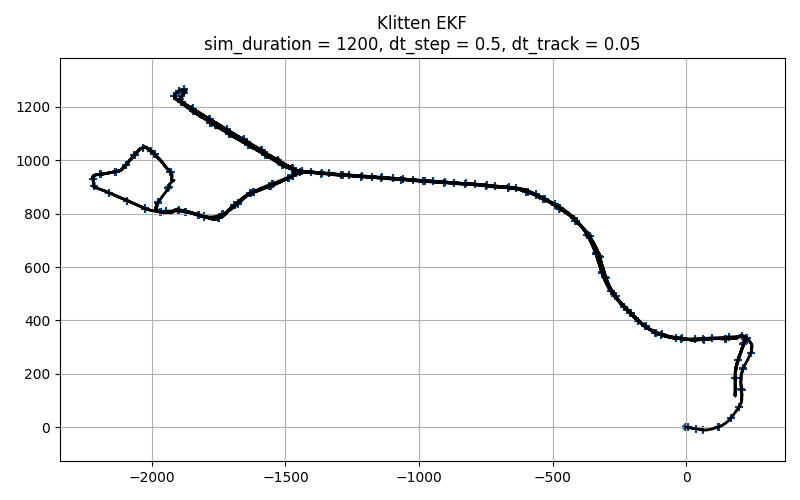

Chart has been saved in: C:/Users/wq138/OneDrive - mailbox.tu-dresden.de/Diplomarbeit/sim_Ergebnisse/Klitten_EKF_sim_duration=1200_dt_step=0.5_dt_track=0.05(2).png


In [34]:
df_ksigma = run_CTRV_EKF(sim_duration = 1200, dt_step = 0.5, dt_track = 0.05)

## Protection Level durch Ksigma berechnen

$$
PL_{kSigma, posH} = k_{posH} \cdot \sigma_H
$$

$$
\cancel{PL_{kSigma, posV} = k_{posV} \cdot \sigma_U}
$$

$$
PL_{kSigma, \psi} = k_{\psi} \cdot \sigma_{\psi}
$$


$$
\sigma_H = \sqrt{\frac{\sigma_E^2 + \sigma_N^2}{2}} + \sqrt{\left(\frac{\sigma_E^2 + \sigma_N^2}{2}\right)^2 + \sigma_{EN}^2}
$$


In [35]:
df_ksigma.head()

,time/s,time step k,X,P,PL_ksigma_posH
0,0.5,1,[[2.286236679250...,[[50.01229596394...,15301.681750
1,1.0,2,[[-0.20727339262...,[[0.018340498941...,0.112105
2,1.5,3,[[-0.20678652094...,[[0.002470065826...,0.015325
3,2.0,4,[[-0.20658189575...,[[0.001461067758...,0.009706
4,2.5,5,[[-0.20659787224...,[[0.001210141133...,0.008379


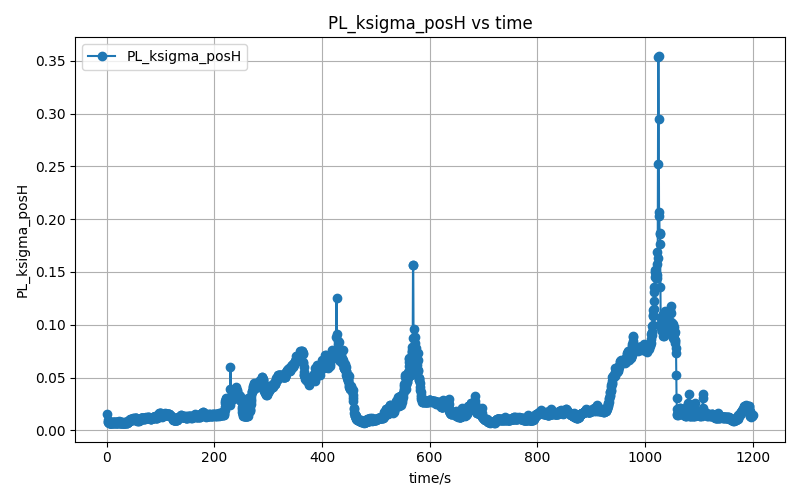

In [36]:
import matplotlib.pyplot as plt

# Replace the placeholder data with your actual df_EKF_update DataFrame
time = df_ksigma['time/s'][2:]
PL_ksigma_posH = df_ksigma['PL_ksigma_posH'][2:]

# Create the plot
fig2 = plt.figure(figsize=(8, 5), tight_layout=True) 
plt.plot(time, PL_ksigma_posH, marker='o', linestyle='-', label='PL_ksigma_posH')
plt.xlabel('time/s')
plt.ylabel('PL_ksigma_posH')
plt.title('PL_ksigma_posH vs time')
plt.legend()
plt.grid(True)
plt.show()
